In [2]:
from finetuning_functions import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os


In [12]:
parent_dir = "D:/Uni/Master-Thesis/daten/20250522/Dicom-20250522_vollstaendig/DICOM_translated/Echtzeit_Belastung/"

slice_liste = [d for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))]
selected_slice = 6
path = os.path.join(parent_dir, slice_liste[selected_slice]) + "/"

#dicom_liste = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

sortedDicom,sortedArr,AT,amountFrames = read_dicomDir(path)
print(path)

D:/Uni/Master-Thesis/daten/20250522/Dicom-20250522_vollstaendig/DICOM_translated/Echtzeit_Belastung/58_mpi92_bSSFP_FOV320_16x8mm_33ms_10min_SA_Slice_7_681.6/mpi92_bSSFP_FOV320_16x8mm_33ms_10min_SA_Slice_7_681.6_dyn_00001.dcm
D:/Uni/Master-Thesis/daten/20250522/Dicom-20250522_vollstaendig/DICOM_translated/Echtzeit_Belastung/58_mpi92_bSSFP_FOV320_16x8mm_33ms_10min_SA_Slice_7_681.6/


Anleitung sollte angeben, wo die ROI hingesetzt wird. Die Programmierung wird darauf ausgerichtet.
Die Anleitung von Lena kann hier eingebaut werden.

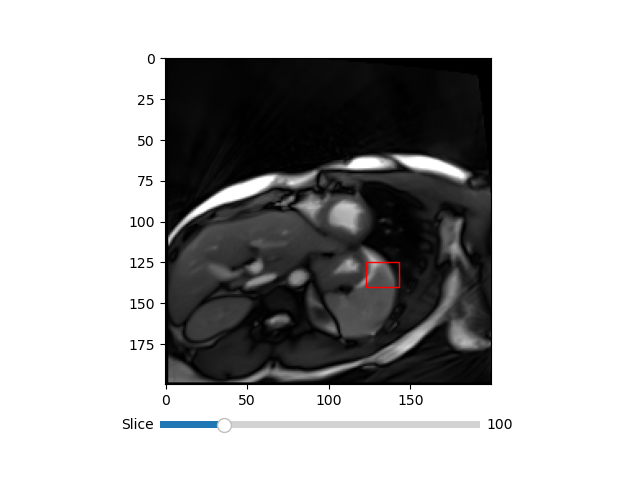

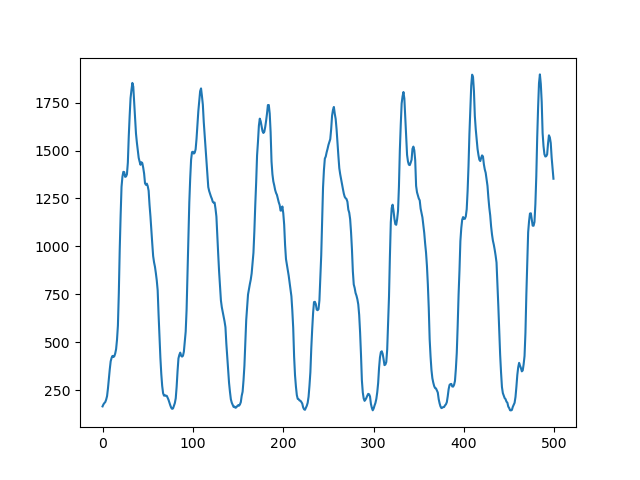

In [19]:
#hier werden die DICOM-Bilder im Zeitstempel-Ordner nach ihrer AT geordnet und das erste Bild zur Kontrolle dargestellt
ArrayDicomsort = sortedDicom[:,:,AT[:,1].argsort()]

#Auswahl eines Rechteckes zur Darstellung einer Signalintensitäts-Kurve
#Das Rechteck sollte an einer Stelle im DICOM-Bild positioniert, werden, an der sich das Bild atemabhängig verändert
#z.B. Thoraxwand oder Zwerchfell
#ROI
x, y = 123, 125
width = 20
height = 15
# 200 x 200 Format
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import matplotlib.patches as patches
%matplotlib widget
# Initialwerte
slice_init = 100
max_slice = ArrayDicomsort.shape[2] - 1  # maximale Anzahl der Slices

# Plot erstellen
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.2)  # Platz für Slider


# Erstes Bild + Rechteck
img = ax.imshow(ArrayDicomsort[:, :, slice_init], cmap='grey')
rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

# Slider-Achse erstellen
ax_slider = plt.axes([0.25, 0.1, 0.5, 0.03])
slider = Slider(ax_slider, 'Slice', 0, max_slice, valinit=slice_init, valfmt='%0.0f')

# Update-Funktion für Slider
def update(val):
    slice_idx = int(slider.val)
    img.set_data(ArrayDicomsort[:, :, slice_idx])
    fig.canvas.draw_idle()

slider.on_changed(update)

plt.show()


#Die Signalintensitätskurve wird geplottet
#x-Achse = Bild-Nr.(sortiert)
#y-Achse = durchschnittliche Signalintensität des ausgewählten Rechteckes
#Signal über eine Bildsequenz
vol = []
for i in range(0,ArrayDicomsort.shape[2]):
    vol.append(np.mean(ArrayDicomsort[x:x+width,y:y+height,i]))
    
#Ablesen des exakten Zeitstempels aus den MRT-Bildern
plt.figure()
plt.plot(vol[:])

# Korrelation

In [21]:
# Bellow Signal
#defining the first value that is part of the respiratory bellows curve
filename = 'echtzeit-spiroergo-05-20250522-1732.resp'
sig_rb, real_time_bellow = read_bellow(filename)
#sig_rb = np.genfromtxt(filename + '_cleaned.resp')

LogStartMDHTime: 63167587


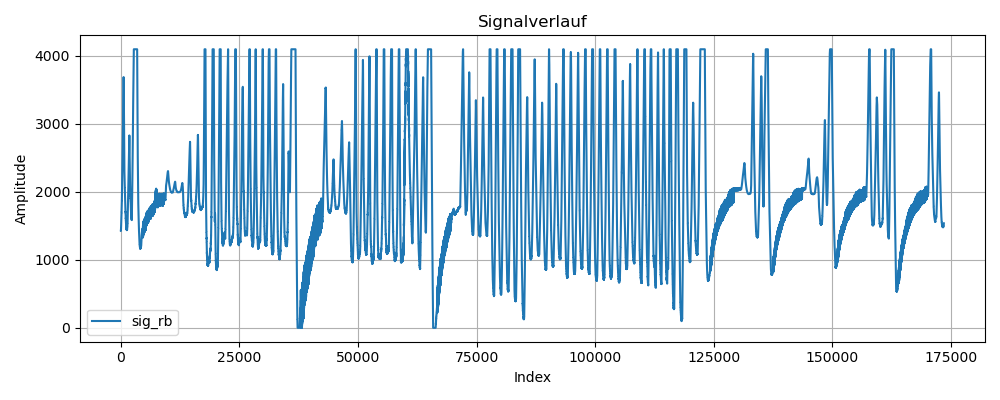

In [23]:
perc = int(len(sig_rb)*0.4)
perc_end = int(len(sig_rb)*0.5)
plt.figure(figsize=(10, 4))
plt.plot(sig_rb[perc:perc_end], label='sig_rb')
plt.title("Signalverlauf")
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
#Einladen der Daten und Verschiebungen, berechnet aus dem ersten Schritt der Korrelation
indizes = np.load('indizes.npy')
# Gebe hier die Uhrzeit Zeitstempel EKG aus dem Korrelationsskript 
zeit_start_zeitstempel_spiro = "18:13:53"

# Anpassen und Berechnen der Verschiebung aus der ersten Korrelation 
sig_rb = cut_bellow_data(sig_rb, AT, real_time_bellow)
# Umwandlung in datetime-Objekte (ein fiktives Datum muss mitgegeben werden)

# Mit den zeiten, berechne die unterschiedlichen Timestamps vom ersten Bild zum letzten Bild im Slice für Spiro
# - ist verschiebung nach rechts, + nach links
manuelle_verschiebung_s = 0 # in sekunden
volume_data_spiro = cut_spiro(AT, zeit_start_zeitstempel_spiro, manuelle_verschiebung_s)

diff_zeit_seconds_between_first_last = berechne_zeitinformationen(AT, zeit_start_zeitstempel_spiro)
# Interpolation des Volumens aus der Spirometrie an das Volumen aus der Signalintensitätskurve

# Zeitraster Volume
volume_time_data = np.linspace(0, diff_zeit_seconds_between_first_last, len(vol))
# Zeitraster Spiro_Volume
vol_spiro_time = np.linspace(0,diff_zeit_seconds_between_first_last,len(volume_data_spiro))
# Gemeinsamer Zeitraster
common_time = volume_time_data
# Interpolation von Datensatz A auf gemeinsamen Raster
f_a = interp1d(vol_spiro_time, volume_data_spiro, kind='linear')
spiro_vol_interpol = f_a(common_time)

vol_mod = [vol_value/np.mean(vol) for vol_value in vol]
    

18:36:12.410
delta: 1:03:24.823000
Differenz ersten slice und Bellow Start: 3804.823 Sekunden
18:36:12.410
Cutoff der Spirodaten vom Anfang bis zum Timestamp 10704
Der Slice beginnt 1900-01-01 18:36:12.410000
Differenz: 1339.41 Sekunden
Zeitspanne SliceVolumen: 16.617
167426
Insgesamtes Abschneiden 178130.25
Länge der Spirodatei 2077 und in Sek 16.616
Erster Slice beginnt um 18:36:12.410
Differenz Spirostart zu erstem Slice: 1339.410 s
Zeitspanne zwischen erstem und letztem Slice: 16.617 s


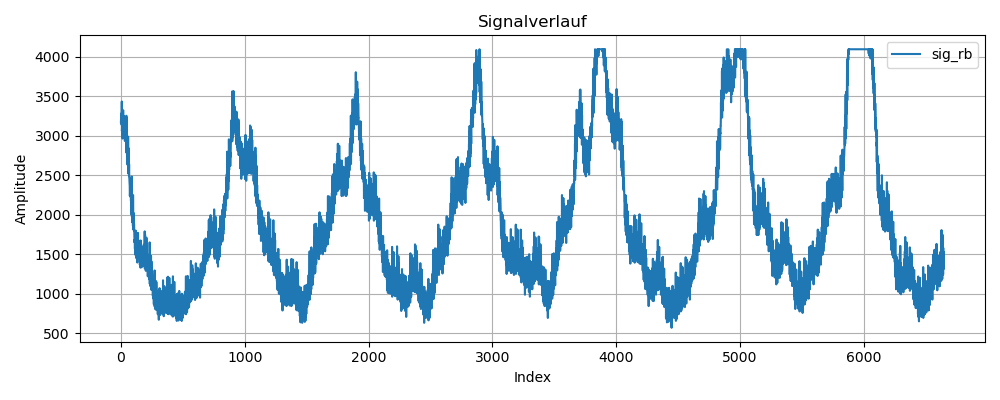

In [27]:
plt.figure(figsize=(10, 4))
plt.plot(sig_rb, label='sig_rb')
plt.title("Signalverlauf")
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
from datetime import datetime, timedelta
only_AT = [at[1] for at in AT]
SR_spiro = 8
dicomtime = str(only_AT[0])
timestamps = [convert_dicom_time(dicomtime)]
while len(timestamps) < len(volume_data_spiro):
    timestamps.append(timestamps[-1] + timedelta(microseconds=(SR_spiro*1000)))
    # timestamps der Bilder
timestamps = np.array(timestamps)
volumes = []
for i in range(len(only_AT)):
    time = convert_dicom_time(str(only_AT[i]))
    #print(time)
    threenn = pick_three_closest_timestamps(timestamps, time)
    v = np.median(volume_data_spiro[threenn])
    volumes.append(v)

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_downsample(signal, target_length):
    factor = len(signal) // target_length
    # Nur so viele Daten verwenden, dass es aufgeht
    trimmed = signal[:factor * target_length]
    reshaped = trimmed.reshape(target_length, factor)
    return reshaped.mean(axis=1)

# Beispielanwendung
sig_rb_smooth = smooth_downsample(sig_rb, 500)
sig_rb_smooth = sig_rb_smooth / np.mean(sig_rb_smooth)

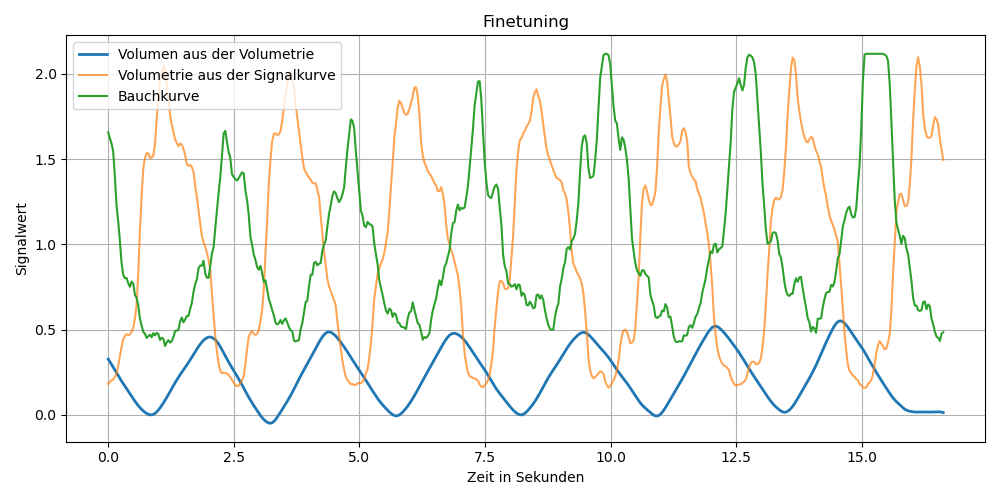

In [35]:
from scipy.signal import find_peaks

plt.figure(figsize=(10, 5))
plt.plot(volume_time_data, spiro_vol_interpol, label='Volumen aus der Volumetrie', linewidth=2)
plt.plot(volume_time_data, vol_mod, label='Volumetrie aus der Signalkurve', alpha=0.7)
#plt.plot(volume_time_data,volumes, label = "Volumen mit pick_three_method" )
plt.plot(volume_time_data, sig_rb_smooth, label = "Bauchkurve" )

plt.title("Finetuning")
plt.xlabel("Zeit in Sekunden")
plt.ylabel("Signalwert")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

6 = 19:28:39.165000, 125, 123
7 = 19:28:56.480000, 125, 123
8 = 19:29:13.797000, 125, 123
9 = 19:29:31.112000, 112, 145
10 = 19:29:48.430000, 112, 145
11 = 19:30:05.745000, 112, 145
12 = 19:30:23.060000, 70, 130
13 = 19:30:40.377000, 60, 130
14 = 19:30:57.692000, 60, 130

In [24]:
# neue Indizes
print(indizes)
manuelle_verschiebung_timesteps = manuelle_verschiebung_s  / 0.008
indizes[1] = indizes[1] + manuelle_verschiebung_timesteps
print(indizes)

[986559  10707]
[986559  10707]


In [26]:
np.save('indizes.npy', indizes)

In [ ]:
"""def read_spiro_data(name_spiro):
    name_spiro = name_spiro
    
    file = open(name_spiro, 'r')
    lines = file.read().splitlines()
    file.close()
    # trennt die /t voneinander, wechselt , in ein punkt
    spiro = []
    for line in lines:
        if not line:
            continue
        lineparts = line.split('\t')
        spiro.append([float(i.replace(',','.')) for i in lineparts])
    
    spiro_resorted = list(map(list, zip(*spiro)))
    # Liesst die Daten aus den drei Spiro-Dateien aus
    file = open(name_spiro, 'r')
    lines = file.read().splitlines()
    file.close()
    return spiro_resorted
    
filename_spiro = "205_26_2_2025_21_4raw.log"
spiro_resorted = read_spiro_data(filename_spiro)
flow_data = spiro_resorted[1]
#data_flow_cutoff = np.array(flow_data[int(sig_curve_vol_timestamps + manuelle_verschiebung_timesteps + index_spiro):int(index_spiro + sig_curve_vol_timestamps + manuelle_verschiebung_timesteps + spiro_slice_timesteps)])
dt = 0.008  # in Sekunden

# Mit den zeiten, berechne die unterschiedlichen Timestamps vom ersten Bild zum letzten Bild im Slice für Spiro
# - ist verschiebung nach rechts, + nach links
manuelle_verschiebung_s = 0 # in sekunden
data_flow_cutoff = cut_spiro(AT, zeit_start_zeitstempel_spiro, manuelle_verschiebung_s)

# Zeitachse erzeugen
t = np.arange(0, len(data_flow_cutoff) * dt, dt)"""